# Liver Segmentation

All of the whole slide images have regions corresponding to the organ per se and empty regions corresponding either to background or vessels (blood vessels or bile ducts). In this pipeline we will look for these organs. An optional objective will be to detect accessory vessels as well.

In [1]:
from pathlib import Path

from napari_czifile2.io import CZISceneFile
import numpy as np
from skimage.filters import gaussian, threshold_otsu
from skimage.morphology import (
    binary_opening,
    disk,
    label,
    remove_small_objects,
    remove_small_holes,
)
from skimage.measure import regionprops

c:\Users\agucor\Anaconda3\envs\bile_duct_clf\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


First we should choose the image file, select the scene and load the array.

In [2]:
DATA_DIR = Path("../data/123 E9.czi")

In [3]:
file = CZISceneFile(DATA_DIR, 2)

In [4]:
img = np.squeeze(file.asarray())

We can use the nuclei staining channel, perform some gross blurring, and apply Otsu thresholding.

In [5]:
nuclei_channel = img[0]

In [6]:
nuclei_channel = gaussian(nuclei_channel, 20)

In [7]:
threshold = threshold_otsu(nuclei_channel)

In [16]:
liver_masks = nuclei_channel > threshold

Now that we have a mask, we can do some opening to remove small nuclei and smooth borders. We can apply algorithms to remove holes and small objects we don't care about. Let's end with a labelling step to enumerate with an identifier each structure.

In [17]:
liver_masks = binary_opening(liver_masks, footprint=disk(30, decomposition="sequence"))

In [18]:
liver_masks = remove_small_holes(liver_masks, area_threshold=10**8)

In [19]:
liver_masks = label(liver_masks)

In [20]:
liver_masks = remove_small_objects(liver_masks, min_size=10000)

In [21]:
areas = regionprops(liver_masks)

In [22]:
for area in areas:
    print(area.area)

20225484.0
62522381.0
846403.0


22-Nov-23 16:11:32 - vispy    - WARNING  - DirectWrite: CreateFontFaceFromHDC() failed (Indicates an error in an input file such as a font file.) for QFontDef(Family="", pointsize=12, pixelsize=16, styleHint=5, weight=50, stretch=100, hintingPreference=0) LOGFONT("MS Sans Serif", lfWidth=0, lfHeight=-16) dpi=240
c:\Users\agucor\Anaconda3\envs\bile_duct_clf\Lib\site-packages\napari\_vispy\layers\image.py:274: UserWarning: data shape (27758, 13063) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
c:\Users\agucor\Anaconda3\envs\bile_duct_clf\Lib\site-packages\napari\_vispy\layers\image.py:274: UserWarning: data shape (27758, 13063) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
c:\Users\agucor\Anaconda3\envs\bile_duct_clf\Lib\site-packages\napari\_vispy\layers\image.py:274: UserWarning: data shape (27758, 13063) exceeds GL_

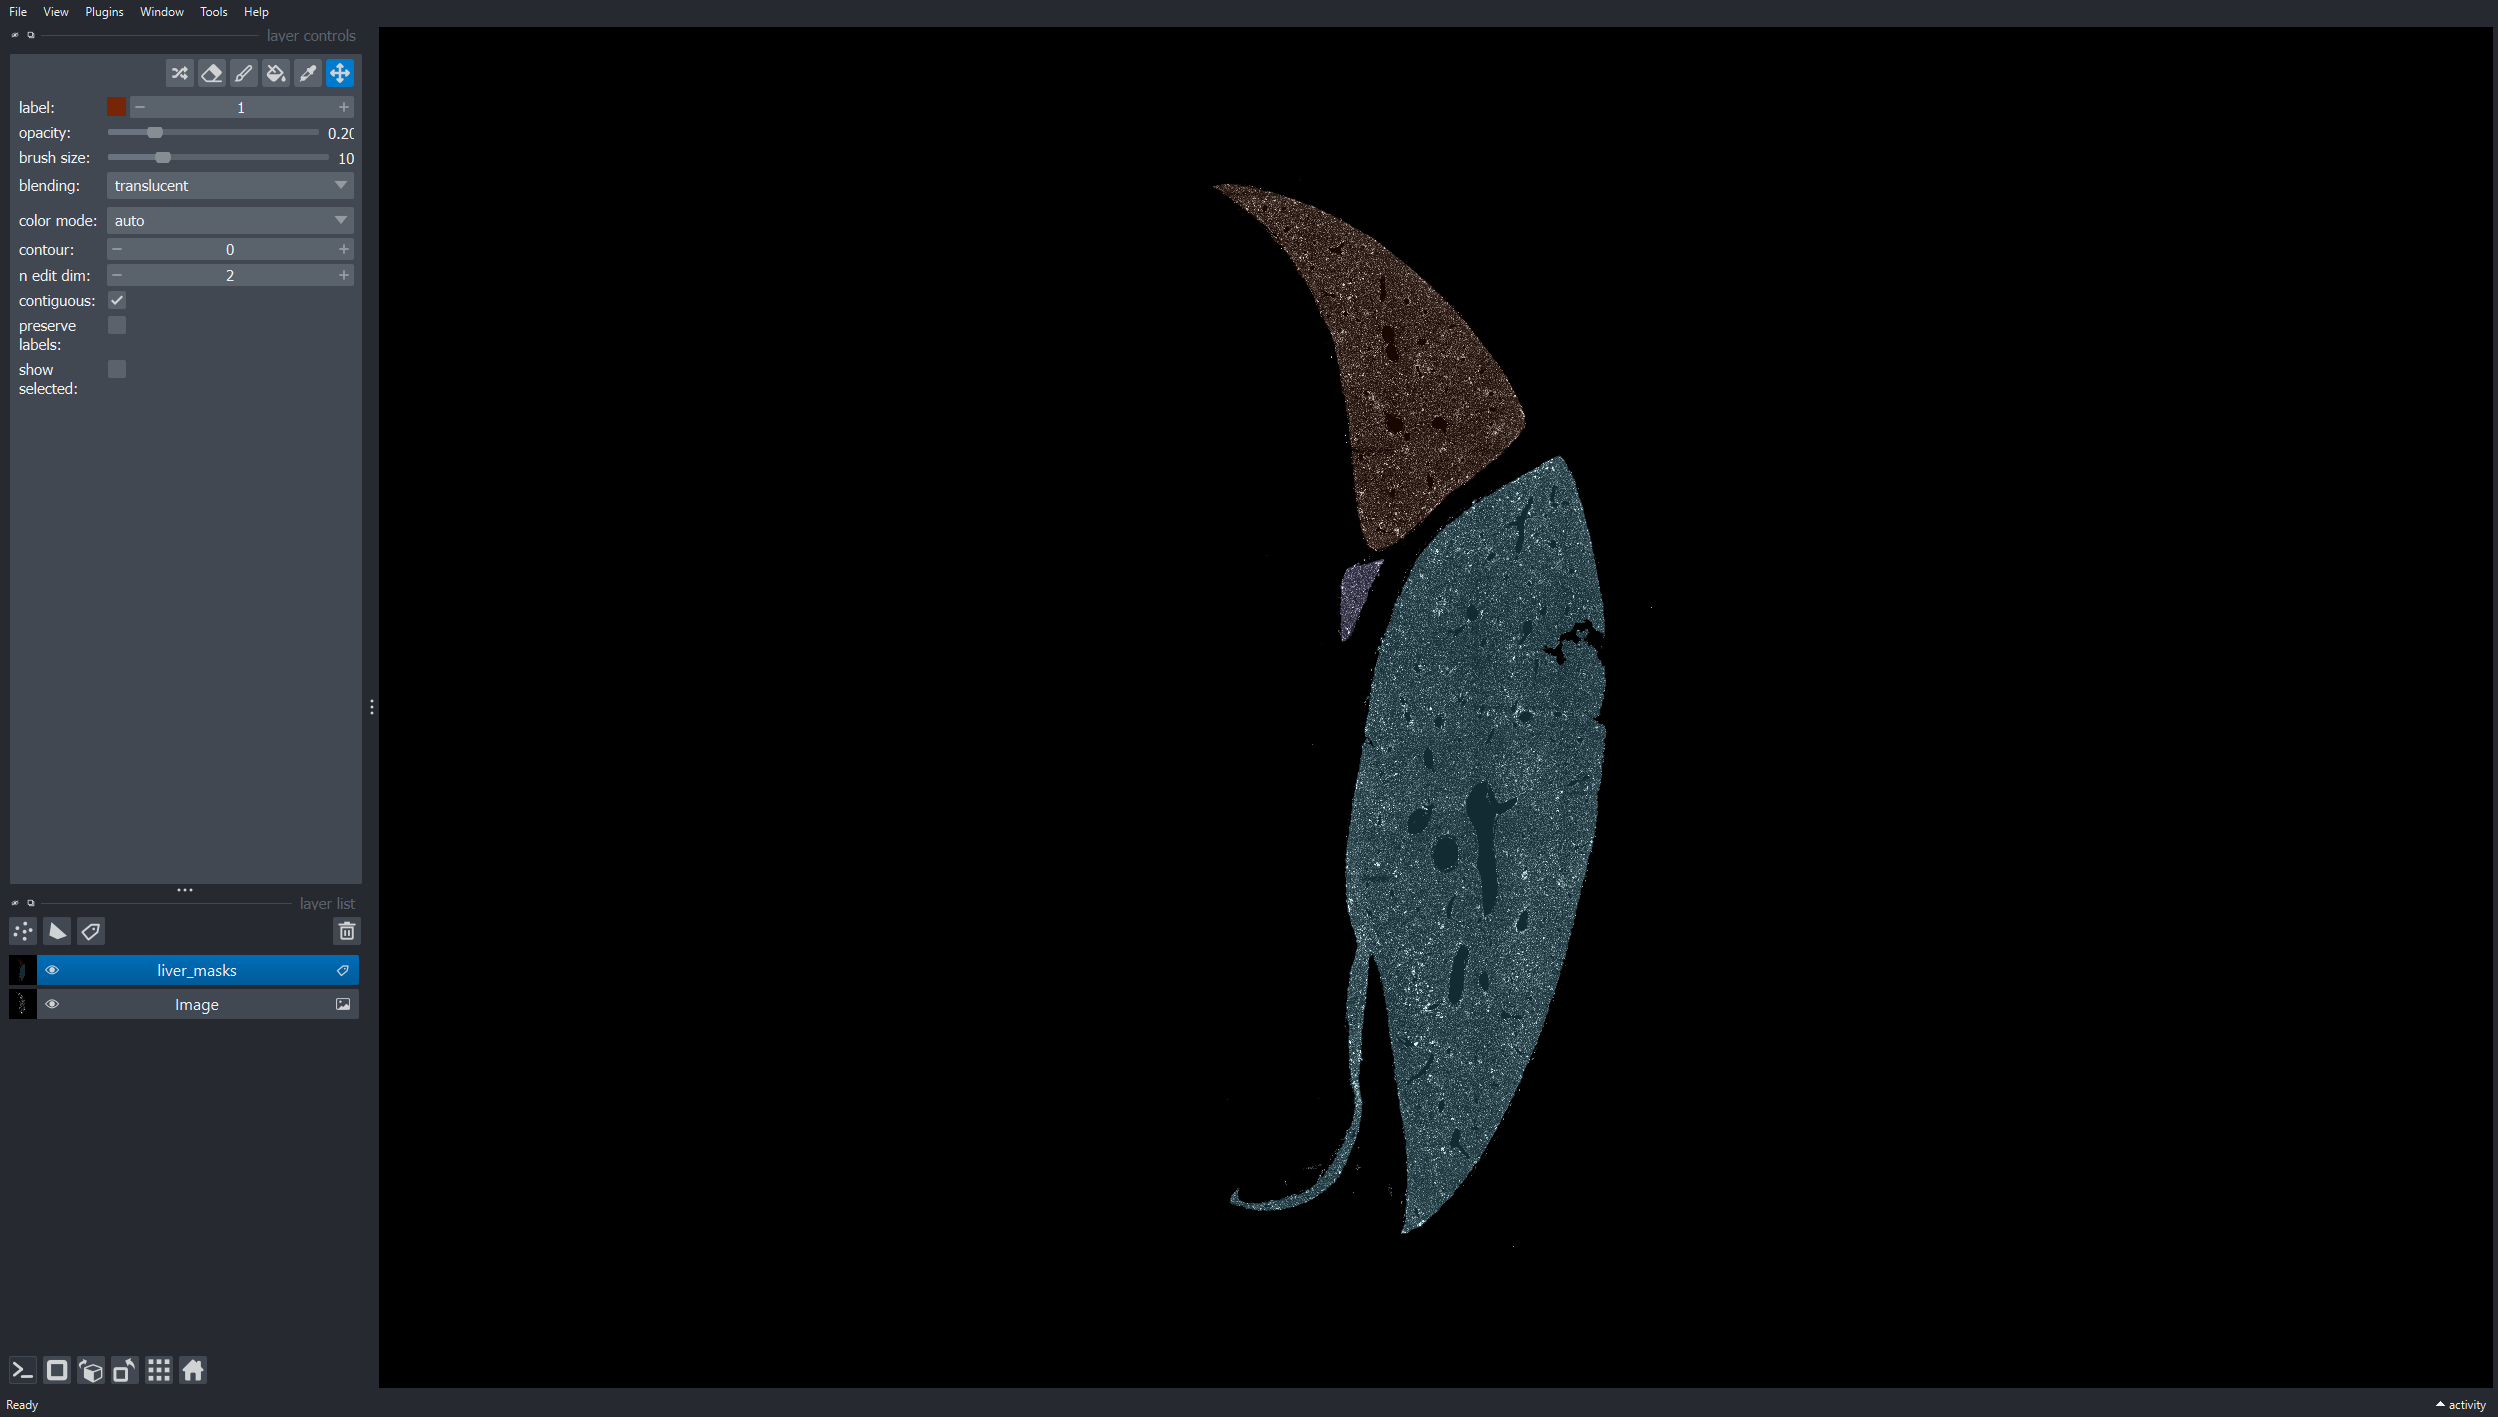

In [23]:
import napari

viewer = napari.Viewer()
viewer.add_image(img[0])
viewer.add_labels(liver_masks, opacity=0.2)
napari.utils.nbscreenshot(viewer)

The areas detected and the regions look good.